## Problem Statement:
In today's customer-centric landscape, businesses are continually seeking innovative approaches to understand their customers better. An effective method of assessing emotions without direct customer queries is to accurately detect sentiments from sources like reviews, chat interactions, tweets, blog posts, and more. Thanks to the emergence of advanced algorithms and enhanced computational capabilities, Natural Language Processing (NLP) now empowers us to discern emotions from written text and respond appropriately.

#### *The Project involves utilizing advanced architectures to detect and predict customer emotions based on Twitter messages, thus addressing this challenge effectively.*

   ### Descriptions of different emotions:
   
      sadness (0), joy (1), love (2), anger (3), fear (4).

# 1. Importing and Installing required libraries

In [5]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


# 2. Text preprocessing 

Covert to Lowercase , expand contractions, remove email add, speacila chr, accented char and html tags.

In [6]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower()) #to lowercase
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #expands contractions : you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x)) #È, è, É, é:-> e
 
    return(df)

In [8]:
df_cleaned = df_cleaned.copy()

In [50]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))
# 'num_words' column will contain the count of words for each text

In [10]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [11]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [12]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [13]:
encoded_dict  = {'sadness':0,'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}

In [16]:
data_train.shape

(14000, 3)

In [17]:
data_test.shape

(6000, 3)

# 3. Load the model 

- Preprocess text data and convert it into tokens that the # BERT model can understand.

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [51]:
# tokenizer and the BERT model saved in specified directories,
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [21]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/kaggle/working/bert-model.zip'

### 4. Tokenizing Training and Testing Data 


In [23]:
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

### Defining a neural network model using TensorFlow and the BERT model 

Neural Network Layers:

- GlobalMaxPool1D(): This is a global max-pooling layer applied to the BERT embeddings. It can be used to summarize information across the entire sequence.
- Dense(128, activation='relu'): This is a fully connected layer with 128 units and a ReLU activation function.
- Dropout(0.1): Dropout layer with a dropout rate of 0.1, which is used for regularization.
- Dense(32, activation='relu'): Another fully connected layer with 32 units and ReLU activation.
- Dense(6, activation='sigmoid'): The final output layer with 6 units (assuming you have 6 emotion categories) and a sigmoid activation function. This layer is used for multi-class classification.

In [25]:
max_len = 70
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [26]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 70)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

# 5. Model fitting and Evaluation

The architecture used is based on BERT (Bidirectional Encoder Representations from Transformers), which is a popular pre-trained transformer model for natural language processing (NLP) tasks. BERT is known for its ability to understand contextual information in text data.

In [29]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
389/389 [==============================] - 282s 723ms/step - loss: 0.5303 - balanced_accuracy: 0.8079 - val_loss: 0.1824 - val_balanced_accuracy: 0.9260
Epoch 2/2
389/389 [==============================] - 286s 736ms/step - loss: 0.1473 - balanced_accuracy: 0.9375 - val_loss: 0.1510 - val_balanced_accuracy: 0.9330


### 6. Save the model

In [30]:
model.save("emotion_classification_model.h5")


In [31]:
# save tokenizer -- used in web application part
tokenizer.save_pretrained("emotion_tokenizer")


('emotion_tokenizer/tokenizer_config.json',
 'emotion_tokenizer/special_tokens_map.json',
 'emotion_tokenizer/vocab.txt',
 'emotion_tokenizer/added_tokens.json',
 'emotion_tokenizer/tokenizer.json')

# 7. Prediction 

In [32]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [33]:
predicted_raw[0]

array([0.2029243 , 0.9990482 , 0.1064749 , 0.26768216, 0.12818982,
       0.16002358], dtype=float32)

In [34]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([1, 1, 1, ..., 0, 0, 4])

In [35]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

# 8. Evaluation parameters

# - Accuracy

In [53]:
accuracy_score(data_test['label'],y_predicted)

0.933

## - Classification Report

In [37]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1739
           1       0.93      0.97      0.95      2028
           2       0.93      0.77      0.84       492
           3       0.92      0.94      0.93       813
           4       0.87      0.94      0.90       712
           5       0.87      0.77      0.82       216

    accuracy                           0.93      6000
   macro avg       0.92      0.89      0.90      6000
weighted avg       0.93      0.93      0.93      6000



## - Confusion Matrix

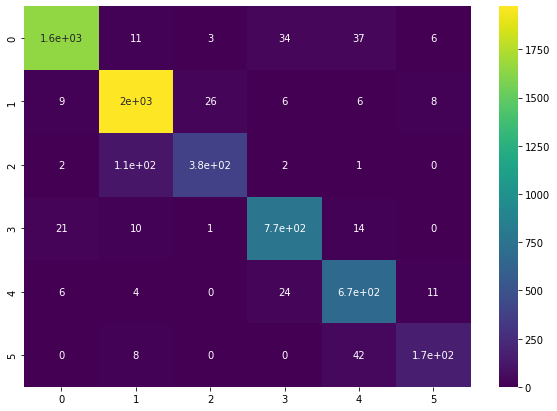

In [38]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# Final Prediction System

In [60]:
texts = input(str('Enter the Tweet: '))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

Enter the Tweet:  Recession has led to increase in depression in students all over the world.


array([[94.254395 , 29.127106 ,  6.9069395, 79.684265 , 59.59931  ,
        10.5605755]], dtype=float32)

In [75]:
print("Emotion Classification of This TWEET :\n")
        # Sort emotions by percentage in descending order
sorted_emotions = {k: v for k, v in sorted(emotions.items(), key=lambda item: item[1], reverse=True)}
for emotion, percentage in sorted_emotions.items():
    st.write(f"{emotion}: {percentage:.2f}%")

Emotion Classification of This TWEET :

* SADNESS  -->  94.254395 

* JOY  -->  29.127106 

* LOVE  -->  6.9069395 

* ANGER  -->  79.684265 

* FEAR  -->  59.59931 

* SURPRISE  -->  10.5605755 



# Thanking you